# Glioma Grading Clinical and Mutation Features

In [1]:
from pathlib import Path
import shutil
import os

import pandas as pd
import matplotlib.font_manager
import warnings
warnings.filterwarnings("ignore")

from src.data_processing import process_data, normalize_dataset
from src.feature_estimators import get_feature_estimator, select_by_correlation_value, concat_important_features
from src.visualize import make_2d_representation

# Data processing
---

In [2]:
DATASETS_PATH = Path('datasets')
train_dataset_path = DATASETS_PATH / 'train.csv'
test_dataset_path = DATASETS_PATH / 'test.csv'

In [3]:
train_dataset = pd.read_csv(train_dataset_path, index_col=0)
test_dataset = pd.read_csv(test_dataset_path, index_col=0)

train_dataset.head()

,Grade,Case_ID,Gender,Age_at_diagnosis,Primary_Diagnosis,Race,IDH1,TP53,ATRX,PTEN,...,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
0,GBM,TCGA-06-A6S0,Male,79 years 183 days,Glioblastoma,black or african american,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
1,LGG,TCGA-HT-8106,Male,53 years 197 days,"Astrocytoma, anaplastic",white,MUTATED,MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,MUTATED,NOT_MUTATED
2,LGG,TCGA-HT-7607,Female,61 years 305 days,"Astrocytoma, NOS",white,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
3,LGG,TCGA-QH-A6X5,Female,58 years 55 days,Mixed glioma,white,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
4,LGG,TCGA-P5-A5F1,Male,30 years 113 days,"Astrocytoma, NOS",white,MUTATED,MUTATED,MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED


### Column Analysis

* The `Grade` column is our target.

* The column `Primary_Diagnosis` has 5 unique values, we will encode it with `LabelEncoder`.

* Column `Case_ID` represents unique id of case, we will remove from our dataset.

* The following columns represent the gen mutations.
    ```text
    IDH1, TP53, ATRX, PTEN, EGFR, CIC, MUC16, PIK3CA,
    NF1, PIK3R1, FUBP1, RB1, NOTCH1, BCOR, CSMD3, SMARCA4,
    GRIN2A, IDH2, FAT4, PDGFRA
    ```
    They might be only `MUTATED` or `NOT_MUTATED`, so we will encode it with `LabelEncoder`.

* The binary type column `Gender` will be encoded with `LabelEncoder` too.

* The `Age_at_diagnosis` column has a string representation of date. We will convert it into the numeric type.

### Missing Data

We detect that 4 cases has no `Age_at_diagnosis` data. We decided to remove them from training set.

In [4]:
encoder = 'Label'

train_dataset = process_data(train_dataset, encoder=encoder, target='Grade')
test_dataset = process_data(test_dataset, encoder=encoder)

2d Representation of our data is presented at the figure below

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

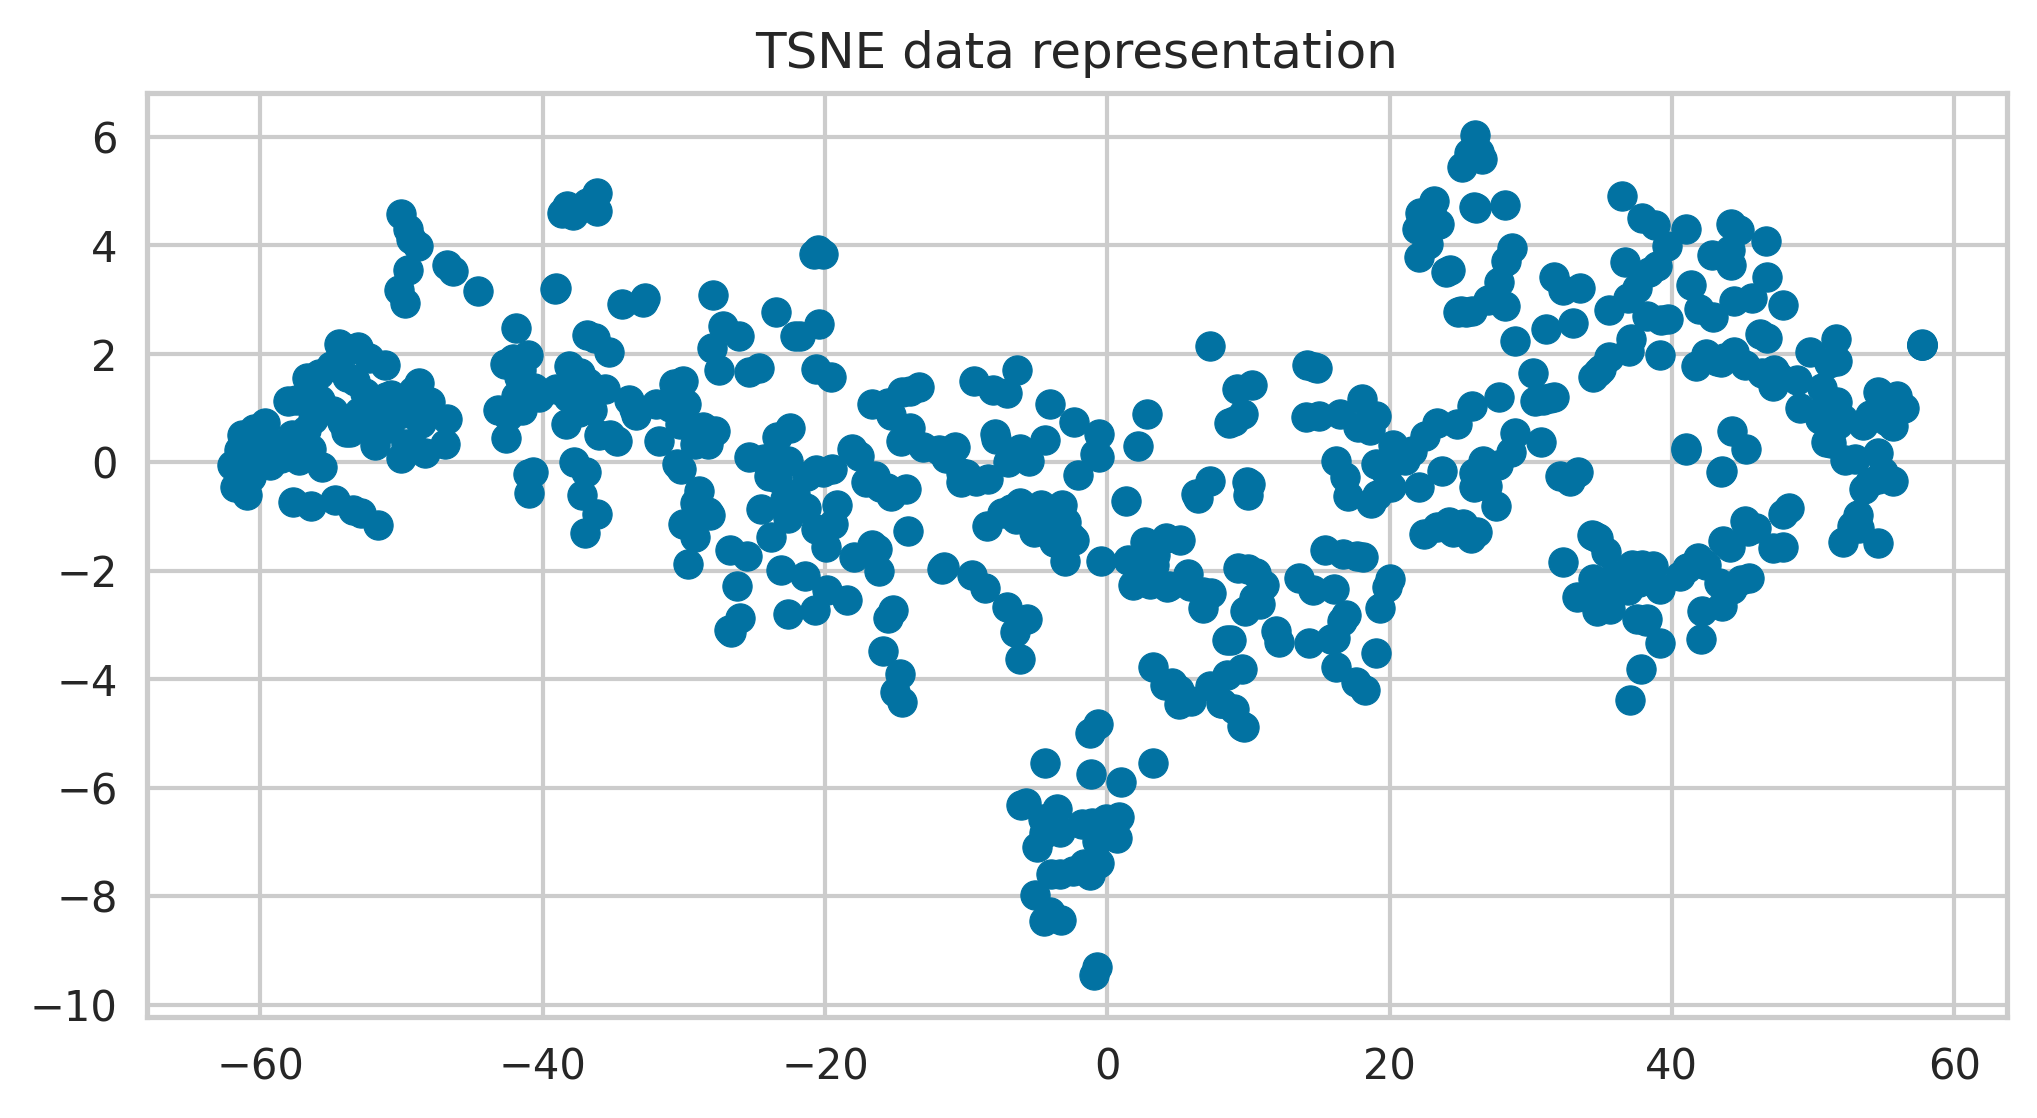

In [5]:
figure = make_2d_representation(train_dataset)

## Feature selection
---

To investigate the most valuable features we decided to calculate some correlation metrics.

In [6]:
data_for_feature_analysis = train_dataset.copy()
training_data = normalize_dataset(train_dataset.drop(columns=['Grade']))
validation_data = normalize_dataset(test_dataset)
targets = data_for_feature_analysis['Grade']

### Mutual information
Mutual information is a lot like correlation in that it measures a relationship between two quantities. The advantage of mutual information is that it can detect any kind of relationship, while correlation only detects linear relationships.


{'Primary_Diagnosis': 0.6749414476523922, 'IDH1': 0.3125375508758952}

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

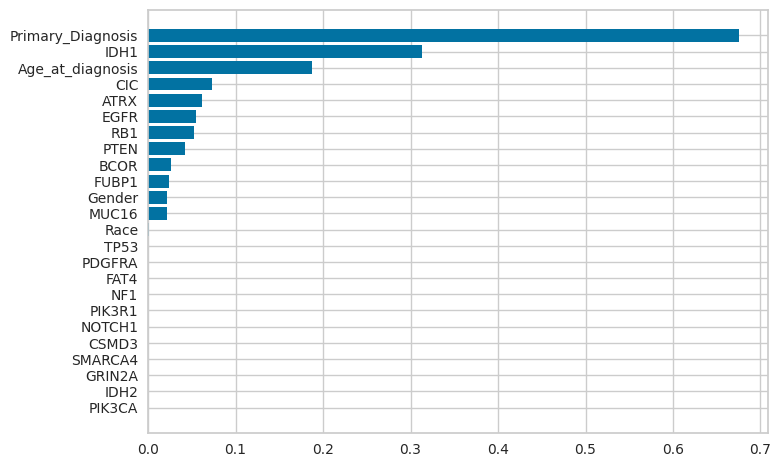

In [7]:
correlation_estimator = get_feature_estimator(training_data, targets, method='mutual_info-classification')
mutual_important_values = select_by_correlation_value(correlation_estimator, min_score=0.2)
mutual_important_values

The most valuable features are:
```text
Primary_Diagnosis, IDH1, Age_at_diagnosis
```

The least valuable features are:
```text
Gender, BCOR, FAT4, PIK3CA, Race, GRIN2A, PIK3R1
```

### Pearson's 

The Pearson correlation measures the strength of the linear relationship between two variables.

{'PTEN': 0.38555722122717984,
 'Primary_Diagnosis': 0.23889448371236569,
 'EGFR': 0.23071818366672014,
 'RB1': 0.22130467653793653,
 'CIC': -0.3039516260660917,
 'ATRX': -0.3385524521113981,
 'Age_at_diagnosis': -0.5056126276597868,
 'IDH1': -0.7174747581507975}

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

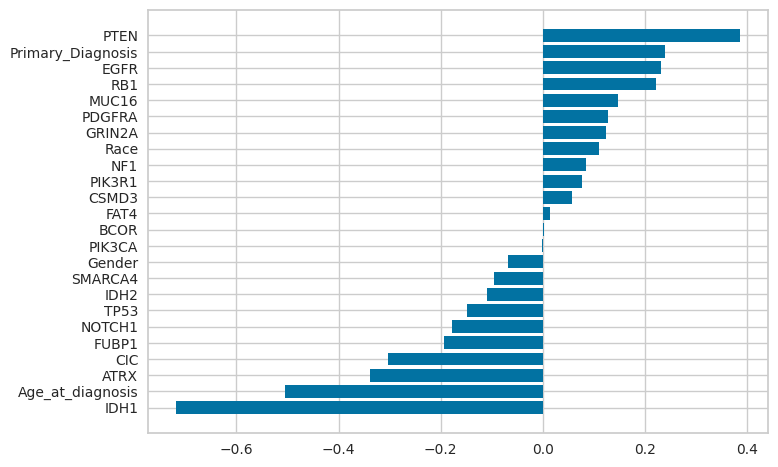

In [8]:
correlation_estimator = get_feature_estimator(training_data, targets, method='pearson')
pearson_important_values = select_by_correlation_value(correlation_estimator, min_score=0.2)
pearson_important_values

The most valuable features are
```text
IDH1, Age_at_diagnosis, PTEN, ATRX, CIC
```

The least valuable features are:
```text
BKOR, PIK3CA, FAT4
```

### Selected Features

We decided to automatically select features if their correlation metric is greater than 0.2

In [9]:
keep_columns = concat_important_features(pearson_important_values, mutual_important_values)
training_data = training_data[keep_columns]
validation_data = test_dataset[keep_columns]
training_data

,PTEN,Age_at_diagnosis,ATRX,Primary_Diagnosis,RB1,IDH1,EGFR,CIC
0,0.451213,1.771841,0.562667,-0.271009,0.216506,0.943548,0.391106,0.391106
1,0.451213,0.160295,0.562667,-1.034646,0.216506,-1.059830,0.391106,0.391106
2,0.451213,0.675255,0.562667,-1.798284,0.216506,-1.059830,0.391106,0.391106
3,0.451213,0.446516,0.562667,0.492628,0.216506,-1.059830,0.391106,-2.556854
4,0.451213,-1.281696,-1.777251,-1.798284,0.216506,-1.059830,0.391106,0.391106
...,...,...,...,...,...,...,...,...
598,0.451213,-3.163137,0.562667,-0.271009,0.216506,0.943548,0.391106,0.391106
599,0.451213,-1.434585,-1.777251,-1.034646,0.216506,-1.059830,0.391106,0.391106
600,0.451213,-1.357545,-1.777251,0.492628,0.216506,-1.059830,0.391106,0.391106
601,0.451213,0.055704,0.562667,2.019903,0.216506,-1.059830,0.391106,0.391106


## Experiments with model

In [10]:
from src.models import logreg_classifier, catboost_classifier, rf_classifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

x_train, x_test, y_train, y_test = train_test_split(training_data, targets, test_size=0.3, random_state=42)

model_map = {
    'Logistic Regression Classifier': logreg_classifier,
    'CatBoost Classifier': catboost_classifier,
    'Random Forest' : rf_classifier,
}
results_path = Path('results')
if (os.path.exists(results_path)):
    shutil.rmtree(results_path)
results_path.mkdir(exist_ok=True)

for model_name, model in model_map.items():
    classifier = model(x_train, y_train)
    prediction = classifier.predict(x_test)
    score = f1_score(y_test, prediction)
    print(f'Model {model_name}: {score}')

    model_file_name = model_name.replace(' ', '_').lower()
    model_result = results_path / f'model_{model_file_name}_{score: .2f}.csv'
    val_prediction = classifier.predict(validation_data)
    val_prediction = [int(not value) for value in val_prediction]
    pd.DataFrame(zip(range(len(val_prediction)), val_prediction),
                 columns=['Id', 'Grade']).to_csv(model_result, index=False)

Model Logistic Regression Classifier: 0.8727272727272727
Model CatBoost Classifier: 0.9956709956709957
Model Random Forest: 0.9868995633187774
